## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP4 - Les LLMs et la génération augmentée de récupération (RAG) pour les questions-réponses<br> Automne 2024 </center>


## Identification de l'équipe:

### Groupe de laboratoire: 01

### Equipe numéro : 04

### Membres:

- **Lucie Legarez - 2413157** (1/3 de contribution, Exploration des données - get_top_k_passages - Évaluation des passages retrouvés - Graphique - État de l'art - Implémentation du nouveau RAG)
- **Presley Kowayeda - 2305686** (1/3 de contribution, Commentaires - evaluate_bleu - encode_sequences - Évaluation des passages retrouvés - RAG figé avec FAISS - Évaluation des réponses - État de l'art - Implémentation du nouveau RAG)
- **Ibrahima Ba - 1943223** (1/3 de contribution, Génération du modèle - Évaluation des passages retrouvés - RAG figé avec FAISS - Dépots Kaggle - État de l'art - Implémentation du nouveau RAG)


* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## 1. Introduction

### 1.1. Description du TP4

Dans ce TP, vous allez travailler sur un système de **génération augmentée de récupération**, ou **RAG** (pour Retrieval Augmented Generation en anglais) qui combine des modèles de langue génératifs et de recherche d'information.

Étant donnée une question, il faudra retrouver les passages les plus pertinents  avec un modèle de recherche. Ensuite, il faudra générer une réponse à la question en utilisant ces passages de texte. Vous aurez finalement à trouver des manières d'améliorer les performances de votre modèle RAG.

L'ensemble est noté sur 100 points.

### Description des données

Les passages donnés sont des textes en anglais de quelques phrases sur divers sujets. Par exemple, les mathématiques, la physique, la chimie, la biologie l'informatique, la musique et la psychologie. En général, les textes abordent des sujets très spécifiques reliés à un domaine. Par exemple, il pourrait y avoir 1000 textes parlant d'informatique et 100 qui abordent, à leur manière, la notion de mémoire. Parmi ces 100 passages, 5 pourraient aborder la mémoire dans un processeur spécifique.

En ce qui concerne les questions, elles sont basées sur les sujets de certains textes précis et on peut y répondre à l'aide d'au moins un des textes. Dans certains cas, plusieurs textes sont nécessaires pour répondre à la question. Par exemple, plusieurs textes pourraient aborder le processeur Intel i7-13700k, mais la question pourrait nécessiter l'information de tous ces textes pour trouver la réponse.
Les questions ont été créées pour faire en sorte que les réponses soient assez courtes. Il peut s'agir d'un simple nombre ou de quelques mots (< 30 mots).


Vous trouverez ~ 13 000 passages dans le corpus pour ~ 1 700 paires de questions / réponses dans le jeu d'entraînement et ~ 500 dans le jeu de validation. Vous devez prédire 500 réponses aux questions du jeu de test.

### Exemple

Par exemple, pour la question

> What type of bonds are used to form branches in glycogen?

Avec l'approche RAG, plutôt que de générer la réponse directement, on va d'abord chercher dans un corpus de passages. Dans cet exemple, un des passages pertinents est :

> **Glycogen Structure and Function** : Glycogen is a molecular polymer of glucose used for energy storage. It is composed of linear chains of glucose molecules linked by α-1,4-glycosidic bonds, with branches formed off the chain via α-1,6-glycosidic bonds. The branches provide additional ""free ends"" for linear chains, allowing for faster glucose release.

Puis on génère une réponse conditionnée par les passages pertinents :

> α-1,6-glycosidic bonds

### Motivation

Le RAG est une approche très populaire en ce moment. Elle permet notamment d'avoir des sources qui supportent les réponses générées, ce qui peut être utile pour la vérification de faits ou pour contrôler les hallucinations. De plus, elle permet d'intégrer des connaissances externes et récentes dans les modèles de génération sans avoir à les ré-entraîner.

### Objectif du TP

Dans ce TP, vous implémenterez plusieurs systèmes de question-réponse. D'abord, vous testerez une approche de prompting qui n'utilise aucun passage pour aider le modèle de génération. Puis vous implémenterez un système figé qui utilise un modèle de plongements figé pour retrouver les $k$ passages les plus pertinents. Ces passages seront ensuite donnés à un modèle de génération figé aussi.

Enfin, vous implémenterez votre propre méthode dans l'objectif d'atteindre les meilleures performances dans la compétition Kaggle.

### Jeux de données

Vous avez 4 fichiers à votre disposition :
- 'rag_texts.csv' : le corpus de passages extraits de Wikipédia.
  - **id** : l'identifiant unique du passage.
  - **text** : le texte du passage.
- 'rag_questions_train.csv', 'rag_questions_val.csv' et 'rag_questions_test.csv' : les questions d'entraînement, de validation et de test.
  - **id** : l'identifiant unique de la question.
  - **question** : La question.
  - **text_id** (sauf pour le fichier de test) : la liste des identifiants des passages pertinents du corpus 'rag_texts.csv' pour la question.
  - **answer** (sauf pour le fichier de test) : la réponse à la question.

### Contraintes

- **Modèle génératif** : pour des raisons d'équité, le seul modèle de génération que vous pouvez utiliser est [microsoft/Phi-3-mini-128k-instruct](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct), disponible sur Hugging Face. Cette contrainte permet de mieux comparer les différentes approches et d'éviter que la performance soit uniquement due à un modèle de génération plus performant.
- Données externes : vous ne pouvez pas utiliser de données externes pour entraîner vos modèles, seulement les données fournies.
- Modèles de plongements à utiliser: [BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)

### 1.2. Librairies permises

Vous pouvez utiliser les librairies suivantes
- Numpy
- Pandas
- HuggingFace
- nltk
- SpaCy
- PyTorch
- faiss
- Langchain
- re


- Pour toute autre librairie, demandez à votre chargé de laboratoire

### 1.3. Infrastructure

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)
- Vous pouvez aussi utiliser l’environnement Google Colab :  https://colab.research.google.com/

### 1.4. Remise

### Échéance

Fin de la session. La date précise sera indiquée dans les boites de remise sur Moodle.


### Livrables

Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


### Critères
1. Implantation correcte et efficace
2. Richesse de la solution proposée
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs
5. Aspect novateur
6. État de l'art synthétisé
7. Performance attendue des modèles
8. Réponses correctes/sensées aux questions de réflexion ou d'analyse

### CODE D’HONNEUR
- __Règle 1__:  Le plagiat de code est bien évidemment interdit. Toute utilisation de code doit être référencée adéquatement. L’utilisation de code ne peut concerner que les architectures de base (par exemple le Transformer). Vous __ne pouvez pas__ soumettre un code écrit par quelqu’un d’autre.
- __Règle 2__: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- __Règle 3__:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.


### 1.5. Kaggle

La compétion Kaggle sera accessible ici: https://www.kaggle.com/t/c970abbf273b4e13a642fce3bfe219be.

Vous devez recréer des équipes de 3 personnes sur Kaggle avec le même nom d'équipe que sur Moodle ainsi que les mêmes membres.

Le TP4 se fera sous forme d’une compétition Kaggle.  Vous devrez utiliser l’environnement Kaggle pour la soumission et l’évaluation de vos meilleurs modèles.  
Pour tester votre modèle au fur et à mesure, vous aurez le droit à 4 soumissions par jour sur Kaggle. Il y aura deux types de résultats : votre « private leaderboard » et votre « public leaderboard » :
- Le « public leaderboard » est calculé sur approximativement 30% des données de test, choisies aléatoirement par Kaggle. Ce score est public et est calculé sur la même tranche de données pour tous les participants.
- Le « private leaderboard » est calculé sur approximativement 70% des données de test et n’est visible qu’à la fin de la compétition. Le résultat final sera basé sur ce leaderboard. Si aucune soumission n’est choisie, la soumission avec le meilleur score sur le « public leaderboard » sera utilisée pour calculer le score sur le « private leaderboard ».

Pour l’évaluation, vous devrez soumettre un fichier de données _tp4_submission.csv_ du même format que le fichier _sample_submission.csv_ (disponible sur le site de la compétition et Moodle).


### 1.6. Description des données et métriques d’évaluation

Dans votre fichier de soumission, il doit y avoir une colonne _id_ et une colonne _answer_. La colonne _id_ doit correspondre à l'identifiant unique de la question et la colonne _answer_ doit correspondre à la réponse générée par votre modèle.

Nous utiliserons la métrique **BLEU**, vue en cours, pour évaluer les réponses générées par rapport au jeu de référence (gold standard).

In [2]:
!pip install transformers sentencepiece accelerate bitsandbytes faiss-gpu datasets

In [3]:
# Import des librairies

import os
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from typing import Optional
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM, pipeline, BitsAndBytesConfig
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
from nltk.translate.bleu_score import sentence_bleu
import nltk
import faiss

In [4]:
print("GPU disponible:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Modèle de GPU:", torch.cuda.get_device_name(0))

GPU disponible: True
Modèle de GPU: Tesla T4


In [5]:
root_path = './'
data_path = root_path + 'data/'

## 2. Analyse exploratoire et modèle de génération simple (15 points)

Pour commencer ce TP, et pour fixer des modèles de base (baselines), vous allez utiliser un modèle de génération simple pour répondre aux questions. Vous utiliserez le modèle de génération **'microsoft/Phi-3-mini-128k-instruct'** disponible sur Hugging Face. Dans cette partie, vous devez simplement générer des réponses aux questions de l'ensemble de validation (_questions_val.csv_) sans utiliser de passages pour aider le modèle.

### 2.1. Chargement des données (5 points)

#### 2.1.1 Taille des données (1 point)

Affichez la taille de tous les jeux de données et quelques questions de l'ensemble d'entraînement

In [6]:
# Chargement des fichiers CSV
texts_df = pd.read_csv('texts.csv')
train_df = pd.read_csv('questions_train.csv')
val_df = pd.read_csv('questions_val.csv')
test_df = pd.read_csv('questions_test.csv')

In [7]:
# Affichage des tailles
print("Taille des jeux de données:")
print(f"Corpus de textes: {len(texts_df)} passages")
print(f"Jeu d'entraînement: {len(train_df)} questions")
print(f"Jeu de validation: {len(val_df)} questions")
print(f"Jeu de test: {len(test_df)} questions")

Taille des jeux de données:
Corpus de textes: 13314 passages
Jeu d'entraînement: 1747 questions
Jeu de validation: 500 questions
Jeu de test: 500 questions


In [8]:
# Affichage de quelques exemples du jeu d'entraînement
print("\nExemples de questions d'entraînement:")
train_df[['question', 'answer']].head()


Exemples de questions d'entraînement:


,question,answer
0,What type of insects are vectors for the Haemo...,"Ceratopogonidae, Culicidae, and Nycteribiidae"
1,What is the basis of the security of the BBS a...,The computational difficulty of factoring larg...
2,What is the purpose of the catalase test in ba...,To identify bacterial species and determine th...
3,What type of cells clear small particles in ve...,Scavenger endothelial cells
4,What information is needed to decrypt a messag...,The user's private key


#### 2.1.2 Analyse exploratoire (4 points)

a) Sur l'ensemble d'entraînement, affichez :
- Le nombre moyen de mots dans une question
- Le nombre moyen de mots dans une réponse
- Le nombre moyen de passages nécessaires pour répondre à une question
- Le nombre minimal de passages nécessaires pour répondre à une question
- Le nombre maximal de passages nécessaires pour répondre à une question


In [9]:
def count_words(text):
    return len(str(text).split())

In [10]:
# Analyse des questions
train_df['question_words'] = train_df['question'].apply(count_words)
avg_question_words = train_df['question_words'].mean()

# Analyse des réponses
train_df['answer_words'] = train_df['answer'].apply(count_words)
avg_answer_words = train_df['answer_words'].mean()

# Analyse des passages nécessaires
# Les text_ids sont stockés comme une liste entre crochets avec des espaces
def count_passages(text_ids):
    # Enlever les crochets et séparer par espaces
    ids = text_ids.strip('[]').split()
    return len(ids)

train_df['num_passages'] = train_df['text_ids'].apply(count_passages)
avg_passages = train_df['num_passages'].mean()
min_passages = train_df['num_passages'].min()
max_passages = train_df['num_passages'].max()

print("\nStatistiques sur l'ensemble d'entraînement:")
print(f"Nombre moyen de mots par question: {avg_question_words:.2f}")
print(f"Nombre moyen de mots par réponse: {avg_answer_words:.2f}")
print(f"Nombre moyen de passages par question: {avg_passages:.2f}")
print(f"Nombre minimal de passages par question: {min_passages}")
print(f"Nombre maximal de passages par question: {max_passages}")


Statistiques sur l'ensemble d'entraînement:
Nombre moyen de mots par question: 10.37
Nombre moyen de mots par réponse: 6.08
Nombre moyen de passages par question: 2.84
Nombre minimal de passages par question: 2
Nombre maximal de passages par question: 4


b) De plus, affichez des histogrammes décrivant la distribution du nombre de mots des questions, des réponses et des textes. Utilisez des bacs (bins) de 50. Commentez vos résultats.

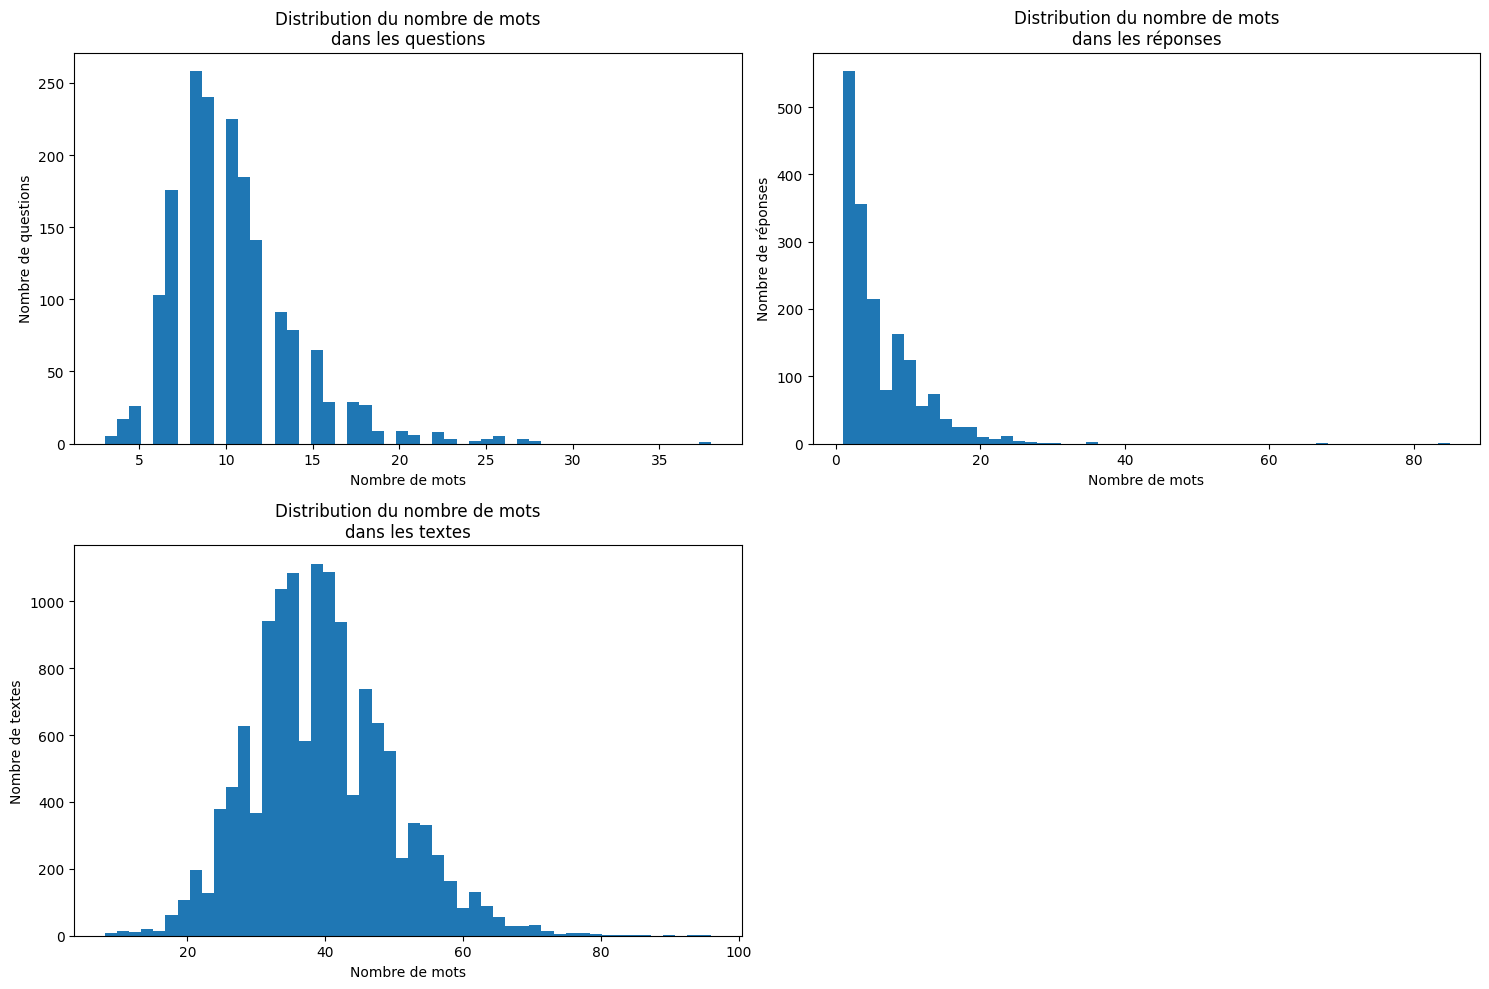

In [11]:
# Calculons aussi le nombre de mots dans les textes
texts_df['text_words'] = texts_df['text'].apply(count_words)

# Création d'une figure avec 4 sous-graphiques
plt.figure(figsize=(15, 10))

# 1. Distribution du nombre de mots dans les questions
plt.subplot(2, 2, 1)
plt.hist(train_df['question_words'], bins=50)
plt.title('Distribution du nombre de mots\ndans les questions')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de questions')

# 2. Distribution du nombre de mots dans les réponses
plt.subplot(2, 2, 2)
plt.hist(train_df['answer_words'], bins=50)
plt.title('Distribution du nombre de mots\ndans les réponses')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de réponses')

# 3. Distribution du nombre de mots dans les textes
plt.subplot(2, 2, 3)
plt.hist(texts_df['text_words'], bins=50)
plt.title('Distribution du nombre de mots\ndans les textes')
plt.xlabel('Nombre de mots')
plt.ylabel('Nombre de textes')

# Ajuster la mise en page
plt.tight_layout()
plt.show()


COMMENTAIRE:

##### **Distribution du nombre de mots dans les questions** :
L'histogramme montre que la majorité des questions contiennent entre 6 et 14 mots, avec un pic autour de 8-10 mots. Cela indique que les questions sont généralement courtes, ce qui pourrait signifier qu'elles sont formulées de manière concise pour des réponses précises.

##### **Distribution du nombre de mots dans les réponses** :
La distribution est très asymétrique, avec une majorité de réponses contenant peu de mots (moins de 10). Cela montre que les réponses sont généralement très concises. Cependant, quelques réponses plus longues dépassent les 20 mots, ce qui pourrait indiquer des explications ou définitions plus détaillées pour certaines questions.

##### **Distribution du nombre de mots** :
histogramme montre une distribution symétrique avec une tendance gaussienne. la majorité des textes ont entre 30 et 50 mots avec un pic autour de 35 et 45 mots.

### 2.2. Chargement du modèle et génération des réponses (5 points)

Nous allons maintenant évaluer la performance d'un modèle de langue à répondre aux questions de l'ensemble de validation. Chargez d'abord le modèle **'microsoft/Phi-3-mini-128k-instruct'** avec la librairie `transformers` de huggingface et générez les réponses du modèle à partir de la question. Générez au maximum 32 nouveaux jetons.

In [12]:
# Pipeline de chargement du modèle
generator = pipeline(
    task="text-generation",
    model="microsoft/phi-3-mini-128k-instruct",
    device=0,
    torch_dtype=torch.float16,
    max_new_tokens=32
)

# Génération des réponses
print("Génération des réponses pour l'ensemble de validation...")
questions = val_df["question"].tolist()
generated_responses = []

for question in tqdm(questions):
    response = generator(f"Answer the following question concisely:\nQuestion: {question}\nAnswer:")
    # Extraction de la réponse après "Answer:"
    full_text = response[0]["generated_text"]
    answer = full_text.split("Answer:")[-1].strip()
    # Nettoyage supplémentaire : prendre seulement la première ligne
    answer = answer.split('\n')[0].strip()
    generated_responses.append(answer)

val_df['predicted_answer'] = generated_responses

# Affichage de quelques exemples
print("\nExemples de questions et réponses générées:")
for i in range(5):
    print(f"\nQuestion: {val_df['question'].iloc[i]}")
    print(f"Vraie réponse: {val_df['answer'].iloc[i]}")
    print(f"Réponse générée: {val_df['predicted_answer'].iloc[i]}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.48k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

Génération des réponses pour l'ensemble de validation...


100%|██████████| 500/500 [11:49<00:00,  1.42s/it]


Exemples de questions et réponses générées:

Question: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?
Vraie réponse: It exhibits decreased responsiveness
Réponse générée: Decreased responsiveness to LTD4

Question: What is the key difference in the structure of carbapenems compared to penicillins?
Vraie réponse: A carbon atom replaces the sulfur atom in position 1
Réponse générée: Carbapenems have a different beta-lactam ring structure.

Question: What type of facets are there in the 8-demicubic honeycomb?
Vraie réponse: 8-demicubes and 8-orthoplex facets
Réponse générée: All of the above

Question: What is the legal status of 5F-AMB in the United States?
Vraie réponse: It is a controlled substance
Réponse générée: Scheduled substance under the Controlled Substances Act.

Question: What is converted into estrone sulfamate by 17β-hydroxysteroid dehydrogenase?
Vraie réponse: E2MATE
Réponse générée: Estrone


### 2.3. Évaluation des réponses (3 points)

Complétez la fonction `evaluate_bleu` et utilisez la métrique BLEU pour évaluer les réponses générées par rapport aux réponses attendues sur le jeu de validation. Évaluez votre modèle avec les métriques BLEU-1 et BLEU-2. BLEU-1 ne considère que les unigrammes pour évaluer la réponse et BLEU-2 considère les bigrammes aussi. Pour séparer une séquence en mots, vous pouvez simplement utiliser la fonction `split()`.

In [13]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def evaluate_bleu(df_true: pd.DataFrame, df_pred: pd.DataFrame, bleu_type: int):
    """
    Évalue les réponses générées en utilisant la métrique BLEU.

    Paramètres:
    df_true (pd.DataFrame): DataFrame contenant les vraies réponses avec des colonnes 'id' et 'answer'.
    df_pred (pd.DataFrame): DataFrame contenant les réponses prédites avec des colonnes 'id' et 'answer'.
    bleu_type (int): Nombre (soit 1 ou 2) correspondant aux n-grammes considérés pour la métrique (bleu_type = 1 : BLEU-1, bleu_type = 2 : BLEU-2)

    Retourne:
    float: Score BLEU moyen sur toutes les entrées.
    """
    # Vérification que bleu_type est valide
    if bleu_type not in [1, 2]:
        raise ValueError("bleu_type doit être 1 ou 2")

    # Initialisation du lissage pour éviter les scores nuls
    smoother = SmoothingFunction().method1

    # Calcul des poids selon le type de BLEU
    weights = (1.0,) if bleu_type == 1 else (0.5, 0.5)

    scores = []

    # Pour chaque paire de réponses
    for true_ans, pred_ans in zip(df_true['answer'], df_pred['answer']):
        # Tokenization des réponses en mots
        reference = [true_ans.split()]  # Liste de listes car sentence_bleu attend plusieurs références possibles
        candidate = pred_ans.split()

        # Calcul du score BLEU
        score = sentence_bleu(
            references=reference,
            hypothesis=candidate,
            weights=weights,
            smoothing_function=smoother
        )
        scores.append(score)

    # Retourne la moyenne des scores
    return sum(scores) / len(scores)

# Création des DataFrames pour les vraies réponses et les prédictions
df_true = pd.DataFrame({'answer': val_df['answer']})
df_pred = pd.DataFrame({'answer': val_df['predicted_answer']})

# Calcul et affichage des scores BLEU
bleu1_score = evaluate_bleu(df_true, df_pred, 1)
bleu2_score = evaluate_bleu(df_true, df_pred, 2)

print(f"Score BLEU-1: {bleu1_score:.4f}")
print(f"Score BLEU-2: {bleu2_score:.4f}")

Score BLEU-1: 0.1822
Score BLEU-2: 0.1151


### 2.4. Commentaire (2 points)

Reportez, puis commentez la performance obtenue ici.

PerforPerformance obtenue:

1. **Scores obtenus :**
   - **BLEU-1 :** 0.1822 (18.22%)
   - **BLEU-2 :** 0.1151 (11.51%)

2. **Analyse :**
   - Les scores sont faibles, indiquant une faible similarité entre les réponses générées et les réponses attendues, en particulier pour les bigrammes (BLEU-2).
   - Le modèle semble produire des réponses imprécises ou formulées différemment des attentes.

## 3. Approche RAG figé (45 points)

Dans cette partie, vous allez implémenter une approche simple de RAG figé. On dit ici que le modèle est figé car on ne ré-entraîne aucun modèle. Vous implémenterez deux variantes : avec ou sans l'utilisation d'un algorithme d'indexation.

Dans la méthode d'implémentation du RAG figé, vous allez d'abord retrouver les passages pertinents pour chaque question avec un modèle de plongements de type Transformers, puis générer une réponse conditionnée par ces passages.

Dans cette partie, on utilisera
- le modèle de plongements (embedding-model) **[BAAI/bge-small-en-v1.5](https://huggingface.co/BAAI/bge-small-en-v1.5)** pour obtenir les vecteur de plongements des questions et des passages
- le modèle de génération (generative-model) **[microsoft/Phi-3-mini-128k-instruct](https://huggingface.co/microsoft/Phi-3-mini-128k-instruct)** pour générer les réponses

### 3.1 RAG figé sans indexation (23 points)

#### 3.1.1 Passages pertinents (8 points)

Pour retrouver les passages pertinents, vous devez d'abord encoder les questions et les passages avec le modèle de plongements. Puis, vous devez calculer la similarité cosinus entre les questions et les passages pour retrouver les $k$ passages les plus pertinents pour chaque question.

In [14]:
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm.notebook import tqdm
import torch.nn.functional as F

# Constantes
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32

In [15]:
def encode_sequences(sequences: list, tokenizer, model, device = DEVICE, batch_size = BATCH_SIZE):
    """
    Encode les textes en utilisant le modèle passé en paramètre pour générer les plongements des textes

    Paramètres:
    sequences    : Liste de séquence à transformer en plongements
    tokenizer   : Segmenteur du modèle de plongements
    model       : Modèle de plongements
    device      : Machine sur laquelle les opérations doivent être effectuées
    batch_size  : Taille des lots lors de la génération des traitements
    """
    embeddings = []

    # Passage en mode évaluation
    model.eval()

    # Traitement par lots
    for i in tqdm(range(0, len(sequences), batch_size)):
        batch = sequences[i:i + batch_size]

        # Tokenization avec padding
        encoded = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=512,
            return_tensors='pt'
        ).to(device)

        # Génération des embeddings
        with torch.no_grad():
            output = model(**encoded)
            # Utilisation des embeddings du token [CLS] (premier token)
            batch_embeddings = output.last_hidden_state[:, 0, :]
            # Normalisation des embeddings
            batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
            embeddings.append(batch_embeddings.cpu())

    # Concaténation de tous les embeddings
    return torch.cat(embeddings, dim=0)

# Chargement du modèle de plongements
embedding_model_name = "BAAI/bge-small-en-v1.5"
embedding_tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
embedding_model = AutoModel.from_pretrained(embedding_model_name).to(DEVICE)

# Encodage des passages et questions
print("Encodage des passages...")
passage_embeddings = encode_sequences(
    texts_df['text'].tolist(),
    embedding_tokenizer,
    embedding_model
)

print("Encodage des questions...")
question_embeddings = encode_sequences(
    val_df['question'].tolist(),
    embedding_tokenizer,
    embedding_model
)

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Encodage des passages...


  0%|          | 0/417 [00:00<?, ?it/s]

Encodage des questions...


  0%|          | 0/16 [00:00<?, ?it/s]

In [16]:
def get_top_k_passages(question_embedding, passage_embeddings, k=5):
    """
    Trouve les k passages les plus similaires à une question donnée
    """
    # Calcul des similarités cosinus
    similarities = F.cosine_similarity(
        question_embedding.unsqueeze(0),
        passage_embeddings
    )

    # Récupération des k meilleurs indices
    top_k_indices = torch.topk(similarities, k=k).indices

    return top_k_indices.tolist()

# Récupération des passages les plus pertinents pour chaque question
k = 5  # nombre de passages à récupérer
relevant_passages = []

print("Recherche des passages pertinents...")
for q_emb in tqdm(question_embeddings):
    top_k_indices = get_top_k_passages(q_emb, passage_embeddings, k)
    passages = [texts_df['text'].iloc[idx] for idx in top_k_indices]
    relevant_passages.append(passages)

# Sauvegarde des passages pertinents dans le DataFrame
val_df['relevant_passages'] = relevant_passages

# Affichage d'un exemple
print("\nExemple de question avec ses passages pertinents:")
idx = 0
print(f"Question: {val_df['question'].iloc[idx]}")
print("\nPassages pertinents:")
for i, passage in enumerate(val_df['relevant_passages'].iloc[idx], 1):
    print(f"\n{i}. {passage}")

Recherche des passages pertinents...


  0%|          | 0/500 [00:00<?, ?it/s]


Exemple de question avec ses passages pertinents:
Question: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?

Passages pertinents:

1.  Polymorphism in the CYSLTR2 gene has been associated with the inheritance of asthma in separate populations. The M201V variant of CYSLTR2 exhibits decreased responsiveness to LTD4, suggesting that this hypo-responsiveness underlies its asthma transmission-protecting effect.

2.  Cysteinyl leukotriene receptor 2 (CYSLTR2) is a receptor that binds to cysteinyl leukotrienes (CysLTs) and contributes to mediating allergic and hypersensitivity reactions in humans. It is expressed in various cell types, including blood eosinophils, platelets, and tissue mast cells.

3.  The human CYSLTR2 gene maps to chromosome 13 and consists of four exons. The protein encoded by CYSLTR2 is composed of 347 amino acids and shares only 31% amino acid identity with the CysLTR1 protein. CYSLTR2 is a G protein-coupled receptor that activates the Gq a

#### 3.1.2 Évaluation des passages retrouvés avec Recall@k et precision@k (7 points)

Maintenant que les passages ont tous été encodés, on peut évaluer si les passages retrouvés sont pertinents. En prenant les $k$ premiers passages, on peut évaluer si on retrouve les bons passages associés aux questions. C'est un des avantages du système RAG : on peut évaluer de façon indépendante la qualité du système qui retrouve les passages pertinents et de celui qui génère les réponses. Cela permet notamment d'évaluer quels sont les points forts et points faibles du système.

Pour cela, vous allez utiliser les métriques **Precision@k** et **Recall@k** définies dans les équations suivantes. Implémentez ces métriques.

$$\text{Precision@k} = \frac{\text{Nombre d'éléments pertinents dans les k premiers}}{k}$$

$$\text{Recall@k} (Rappel@k) = \frac{\text{Nombre d'éléments pertinents dans les k premiers}}{\text{Nombre total d'éléments pertinents}}$$


In [17]:
def compute_recall_at_k(ground_truth, predictions):
    """
    Calcule la métrique du "Recall@k". On assume que predictions contiennent le bon nombre de passages (=k)

    Paramètres:
    ground_truth : Liste contenant tous les vrais passages associés aux questions (ex : [[1, 2, 3], [4, 5, 6]] si les passages de la question 1 sont [1, 2, 3] et
    les passages de la question 2 sont [4, 5, 6])
    predictions : Liste contenant tous les passages retrouvés pour chacune des questions formattée de la même manière que `ground_truth`

    Retourne:
    Recall moyen
    """
    recalls = []

    # Pour chaque question
    for gt, pred in zip(ground_truth, predictions):
        # Conversion en ensembles pour faciliter l'intersection
        gt_set = set(gt)
        pred_set = set(pred)

        # Calcul du recall pour cette question
        # Nombre d'éléments pertinents retrouvés / Nombre total d'éléments pertinents
        if len(gt_set) > 0:  # Éviter division par zéro
            recall = len(gt_set.intersection(pred_set)) / len(gt_set)
            recalls.append(recall)

    # Retourne la moyenne des recalls
    return sum(recalls) / len(recalls) if recalls else 0

In [18]:
def compute_precision_at_k(ground_truth, predictions):
    """
    Calcule la métrique du "Precision@k". On assume que predictions contiennent le bon nombre de passages (=k)

    Paramètres:
    ground_truth : Liste contenant tous les vrais passages associés aux questions (ex : [[1, 2, 3], [4, 5, 6]] si les passages de la question 1 sont [1, 2, 3] et
    les passages de la question 2 sont [4, 5, 6])
    predictions : Liste contenant tous les passages retrouvés pour chacune des questions formattée de la même manière que `ground_truth`

    Retourne:
    Précision moyenne
    """
    precisions = []

    # Pour chaque question
    for gt, pred in zip(ground_truth, predictions):
        # Conversion en ensembles pour faciliter l'intersection
        gt_set = set(gt)
        pred_set = set(pred)

        # Calcul de la précision pour cette question
        # Nombre d'éléments pertinents retrouvés / Nombre total d'éléments prédits (k)
        if len(pred_set) > 0:  # Éviter division par zéro
            precision = len(gt_set.intersection(pred_set)) / len(pred_set)
            precisions.append(precision)

    # Retourne la moyenne des précisions
    return sum(precisions) / len(precisions) if precisions else 0

#### 3.1.3 Résultat d'évaluation (5 points)
Implémentez la fonction _'retrieve_passages'_ qui retourne les indices des $k$ passages les plus similaires pour une question. Utilisez la similarité cosinus pour comparer les passages et les questions. Évaluez ensuite votre modèle récupérant les passages avec les métriques Precision@k et Recall@k sur le jeu de validation. Calculez avec $k={1, 2, 3, 4, 5}$.

In [19]:
def retrieve_passages(questions: list, passage_embed: torch.Tensor, k: int, embedding_model_tokenizer, embedding_model):
    """
    Retourne les k passages les plus pertinents pour chaque question passée en paramètre
    Paramètres:
    questions : Les questions pour lesquelles on cherche les passages les plus pertinents
    passage_embed : Tenseur contenant les plongements de chaque passage (n, dim)
    k : le nombre de passages à retourner
    tokenizer : Segmenteur du modèle de plongements
    model : Modèle de plongements
    Retourne:
    Les indices des k passages les plus pertinents pour la question
    """
    # Encodage des questions
    question_embed = encode_sequences(
        questions,
        embedding_model_tokenizer,
        embedding_model
    )

    results = []
    # Pour chaque question
    for q_emb in question_embed:
        # Calcul des similarités cosinus
        similarities = F.cosine_similarity(
            q_emb.unsqueeze(0),
            passage_embed
        )
        # Récupération des k meilleurs indices
        top_k = torch.topk(similarities, k=k)
        results.append(top_k.indices.tolist())

    return results

# Évaluation pour différentes valeurs de k
k_values = [1, 2, 3, 4, 5]
results = {}

# Pour chaque valeur de k
for k in k_values:
    # Récupération des passages prédits
    predictions = retrieve_passages(
        val_df['question'].tolist(),
        passage_embeddings,
        k,
        embedding_tokenizer,
        embedding_model
    )

    # Préparation des ground truth
    ground_truth = [str(ids).strip('[]').split() for ids in val_df['text_ids']]
    ground_truth = [[int(id) for id in ids] for ids in ground_truth]

    # Calcul et stockage des métriques
    recall = compute_recall_at_k(ground_truth, predictions)
    precision = compute_precision_at_k(ground_truth, predictions)

    # Stockage des résultats dans le dictionnaire
    results[k] = {
        'recall': recall,
        'precision': precision
    }

    print(f"\nPour k = {k}:")
    print(f"Recall@{k}: {recall:.4f}")
    print(f"Precision@{k}: {precision:.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]


Pour k = 1:
Recall@1: 0.3328
Precision@1: 0.8900


  0%|          | 0/16 [00:00<?, ?it/s]


Pour k = 2:
Recall@2: 0.4933
Precision@2: 0.6750


  0%|          | 0/16 [00:00<?, ?it/s]


Pour k = 3:
Recall@3: 0.6032
Precision@3: 0.5593


  0%|          | 0/16 [00:00<?, ?it/s]


Pour k = 4:
Recall@4: 0.7047
Precision@4: 0.4955


  0%|          | 0/16 [00:00<?, ?it/s]


Pour k = 5:
Recall@5: 0.7752
Precision@5: 0.4384


#### 3.1.4 Graphique (3 points)
Affichez maintenant un graphique de vos résultats de la question précédente en mettant à l'axe des x la valeur de $k$ et à l'axe des y la valeur de la précision et du rappel. Quel est le nombre optimal de passages à passer au modèle en vous basant sur le recall@k et precision@k ? Pourquoi ?

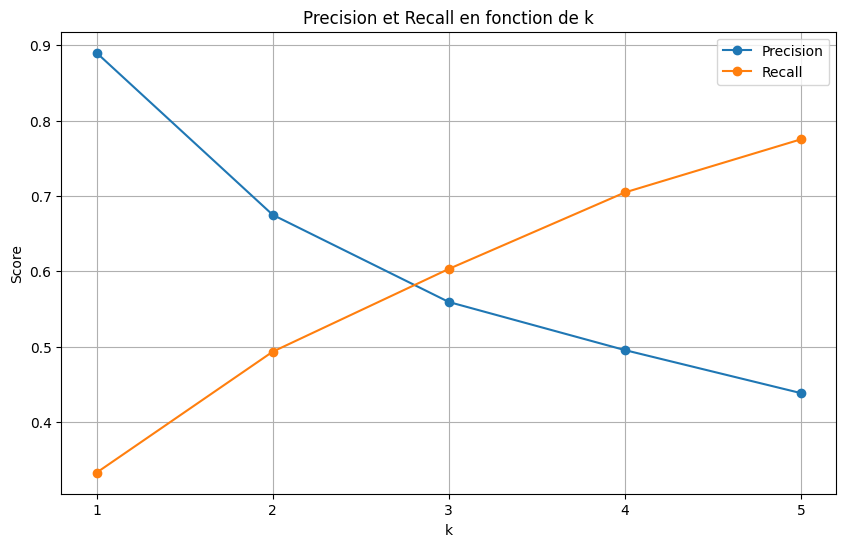

In [20]:
# Création du graphique
plt.figure(figsize=(10, 6))

# Récupération des valeurs à partir du dictionnaire results
precision_values = [results[k]['precision'] for k in k_values]
recall_values = [results[k]['recall'] for k in k_values]

# Tracer les deux courbes
plt.plot(k_values, precision_values, marker='o', label='Precision')
plt.plot(k_values, recall_values, marker='o', label='Recall')

# Personnalisation du graphique
plt.xlabel('k')
plt.ylabel('Score')
plt.title('Precision et Recall en fonction de k')
plt.legend()
plt.grid(True)
plt.xticks(k_values)

plt.show()

### 3.2 RAG figé avec FAISS (14 points)

Maintenant on vous demande d'utiliser FAISS pour l'indexation des plongements des passages.

[FAISS (Facebook AI Similarity Search)](https://ai.meta.com/tools/faiss/) est une bibliothèque open-source développée par Meta pour la recherche de similarité rapide sur des vecteurs denses, comme des embeddings de textes ou d'images. Elle est optimisée pour gérer de grands volumes de données en haute dimension et peut être accélérée avec des GPU. FAISS est largement utilisée pour des systèmes de recommandation ou la recherche d'information à grande échelle. Pour plus de détails, veuillez consulter  [le tutoriel sur Moodle](https://moodle.polymtl.ca/course/view.php?id=2813).


#### 3.2.1 Initialisez l'indexation FAISS avec les plongements des passages (2 points)

Utilisez les plongements des passages générés au niveau de la question 3.1.1 et indexez-les avec FAISS. Vérifiez que le nombre de plongements dans l'objet FAISS est bien le même que le nombre de passages. N'oubliez pas qu'on veut une indexation basée sur la similarité cosinus.

In [21]:
# Conversion des embeddings en numpy pour FAISS
passage_embeddings_np = passage_embeddings.numpy()

# Dimension des embeddings
embedding_dim = passage_embeddings_np.shape[1]

# Initialisation de l'index FAISS pour la similarité cosinus
# On utilise IndexFlatIP car c'est l'index le plus simple pour le produit scalaire (inner product)
index = faiss.IndexFlatIP(embedding_dim)

# Normalisation L2 des vecteurs pour transformer le produit scalaire en similarité cosinus
faiss.normalize_L2(passage_embeddings_np)

# Ajout des vecteurs normalisés à l'index
index.add(passage_embeddings_np)

# Vérification que le nombre de vecteurs indexés correspond au nombre de passages
print(f"Nombre de passages dans le corpus: {len(texts_df)}")
print(f"Nombre de vecteurs dans l'index FAISS: {index.ntotal}")
print(f"Dimension des vecteurs: {embedding_dim}")

Nombre de passages dans le corpus: 13314
Nombre de vecteurs dans l'index FAISS: 13314
Dimension des vecteurs: 384


#### 3.2.2 Récupération des passages avec FAISS (4 points)

Implémentez la fonction _'retrieve_passages_faiss'_ qui retourne les indices des $k$ passages les plus similaires pour une question à l'aide d'un indexation FAISS


In [22]:
def retrieve_passages_faiss(questions: list, vector_index: faiss.IndexFlatL2, k: int, embedding_model_tokenizer, embedding_model):
   """
   Retourne les k passages les plus pertinents pour chaque question passée en paramètre

   Paramètres:
   questions : Les questions pour lesquelles on cherche les passages les plus pertinents
   vector_index : L'objet d'indexation FAISS
   k : le nombre de passages à retourner
   tokenizer : Segmenteur du modèle de plongements
   model : Modèle de plongements

   Retourne:
   Les indices des k passages les plus pertinents pour la question
   """
   # Encodage des questions
   question_embeddings = encode_sequences(
       questions,
       embedding_model_tokenizer,
       embedding_model
   )

   # Conversion en numpy et normalisation
   question_embeddings_np = question_embeddings.numpy()
   faiss.normalize_L2(question_embeddings_np)

   # Recherche des k plus proches voisins
   # D contient les distances, I contient les indices
   D, I = vector_index.search(question_embeddings_np, k)

   # Conversion des indices en liste Python
   results = I.tolist()

   return results

#### 3.2.3 Exécution de FAISS (4 points)

Exécutez maintenant la fonction _"retrieve_passages_faiss"_ pour récupérer les bons passages pour les questions du jeu de validation avec votre k optimal.

In [23]:
# Nous avons vu précédemment que k=3 offrait un bon compromis entre précision et rappel
k_optimal = 3

# Récupération des passages avec FAISS
predictions_faiss = retrieve_passages_faiss(
   val_df['question'].tolist(),
   index,  # notre index FAISS créé précédemment
   k_optimal,
   embedding_tokenizer,
   embedding_model
)

# Préparation des ground truth
ground_truth = [str(ids).strip('[]').split() for ids in val_df['text_ids']]
ground_truth = [[int(id) for id in ids] for ids in ground_truth]

# Calcul des métriques
recall_faiss = compute_recall_at_k(ground_truth, predictions_faiss)
precision_faiss = compute_precision_at_k(ground_truth, predictions_faiss)

print(f"\nRésultats avec FAISS pour k={k_optimal}:")
print(f"Recall@{k_optimal}: {recall_faiss:.4f}")
print(f"Precision@{k_optimal}: {precision_faiss:.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]


Résultats avec FAISS pour k=3:
Recall@3: 0.6032
Precision@3: 0.5593


#### 3.2.4 Calculez les métriques Precision@K et Rappel@K pour les passages retrouvés avec FAISS avec votre k optimal (2 points)

In [24]:
# k optimal déterminé précédemment
k_optimal = 3

# Récupération des passages avec FAISS
predictions = retrieve_passages_faiss(
    val_df['question'].tolist(),
    index,
    k_optimal,
    embedding_tokenizer,
    embedding_model
)

# Préparation des ground truth
ground_truth = [str(ids).strip('[]').split() for ids in val_df['text_ids']]
ground_truth = [[int(id) for id in ids] for ids in ground_truth]

# Calcul des métriques pour k optimal
recall = compute_recall_at_k(ground_truth, predictions)
precision = compute_precision_at_k(ground_truth, predictions)

print(f"\nRésultats avec FAISS pour k optimal = {k_optimal}:")
print(f"Recall@{k_optimal}: {recall:.4f}")
print(f"Precision@{k_optimal}: {precision:.4f}")

  0%|          | 0/16 [00:00<?, ?it/s]


Résultats avec FAISS pour k optimal = 3:
Recall@3: 0.6032
Precision@3: 0.5593


#### 3.2.5 Quelle remarque pouvez-vous faire sur l'utilisation de FAISS en termes de passages retrouvés, de temps d'exécution et de tout autre élément qui vous semble approprié ? (2 points)

> Réponse

On observe que FAISS permet de retrouver rapidement des passages pertinents avec un bon compromis entre précision et rappel. Son temps d'exécution est très rapide, même pour de grandes bases de données, grâce à son optimisation, mais il nécessite des embeddings de qualité et une normalisation préalable pour des résultats optimaux.

### 3.3 Génération des réponses (5 points)

Générez maintenant les réponses des questions sur l'ensemble de validation avec les passages récupérés. Pour générer les réponses, vous devez concaténer les passages pertinents avec la question et donner le tout au modèle de génération. Faites-le sur l'ensemble du jeu de validation. Pour la méthode, vous avez le choix entre les passages retrouvés avec FAISS ou manuellement (avec votre propre implémentation). Faites cela pour toutes les valeurs de $k$: (1, 2, 3 et 4).

In [75]:
def generate_rag_answers(questions, passages_per_question, generator, k):
   """
   Génère des réponses en utilisant RAG

   Paramètres:
   questions : Liste des questions
   passages_per_question : Liste de listes des passages pour chaque question
   generator : Pipeline de génération
   k : Nombre de passages utilisés

   Retourne:
   Liste des réponses générées
   """
   generated_answers = []

   for question, passages in tqdm(zip(questions, passages_per_question), total=len(questions)):
       # On prend les k premiers passages
       context = " ".join(passages[:k])

       # Construction du prompt
       prompt = f"""Use the following passages to answer the question concisely.

Passages:
{context}

Question: {question}
Answer:"""

       # Génération de la réponse
       response = generator(prompt)
       answer = response[0]["generated_text"].split("Answer:")[-1].strip()
       # Garder seulement la première ligne
       answer = answer.split('\n')[0].strip()

       generated_answers.append(answer)

   return generated_answers

# Pour chaque valeur de k
k_values = [1, 2, 3, 4]
rag_answers = {}

for k in k_values:
   print(f"\nGénération des réponses avec k={k}")

   # Récupération des passages avec FAISS pour ce k
   passage_indices = retrieve_passages_faiss(
       val_df['question'].tolist(),
       index,
       k,
       embedding_tokenizer,
       embedding_model
   )

   # Récupération des textes des passages
   passages_per_question = [[texts_df['text'].iloc[idx] for idx in indices]
                          for indices in passage_indices]

   # Génération des réponses
   answers = generate_rag_answers(
       val_df['question'].tolist(),
       passages_per_question,
       generator,
       k
   )

   # Stockage des réponses générées
   rag_answers[k] = answers


Génération des réponses avec k=1


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Génération des réponses avec k=2


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Génération des réponses avec k=3


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]


Génération des réponses avec k=4


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

Affichez un exemple d'invite (prompt) qui sera envoyé au modèle de génération

In [76]:
# Exemple avec k=2 pour une question
example_idx = 0  # on prend la première question comme exemple
k = 2

# Récupération de la question
question = val_df['question'].iloc[example_idx]

# Récupération des passages avec FAISS
passage_indices = retrieve_passages_faiss(
   [question],  # une seule question
   index,
   k,
   embedding_tokenizer,
   embedding_model
)[0]  # prendre le premier résultat car une seule question

# Récupération des textes des passages
passages = [texts_df['text'].iloc[idx] for idx in passage_indices]
context = " ".join(passages[:k])

# Construction du prompt
prompt = f"""Use the following passages to answer the question concisely.

Passages:
{context}

Question: {question}
Answer:"""

print("=== Exemple de prompt ===")
print(prompt)

  0%|          | 0/1 [00:00<?, ?it/s]

=== Exemple de prompt ===
Use the following passages to answer the question concisely.

Passages:
 Polymorphism in the CYSLTR2 gene has been associated with the inheritance of asthma in separate populations. The M201V variant of CYSLTR2 exhibits decreased responsiveness to LTD4, suggesting that this hypo-responsiveness underlies its asthma transmission-protecting effect.  Cysteinyl leukotriene receptor 2 (CYSLTR2) is a receptor that binds to cysteinyl leukotrienes (CysLTs) and contributes to mediating allergic and hypersensitivity reactions in humans. It is expressed in various cell types, including blood eosinophils, platelets, and tissue mast cells.

Question: What is the effect of the M201V variant of CYSLTR2 on responsiveness to LTD4?
Answer:


### 3.4 Évaluation des réponses (3 points)

Utilisez la métrique BLEU (BLEU-1 et BLEU-2) pour évaluer les réponses générées par rapport aux réponses attendues sur le jeu de validation.

In [77]:
# Évaluation des réponses pour chaque k
k_values = [1, 2, 3, 4]
bleu_scores = {}

# Pour chaque valeur de k
for k in k_values:
   # Création des DataFrames pour l'évaluation
   df_true = pd.DataFrame({'answer': val_df['answer']})
   df_pred = pd.DataFrame({'answer': rag_answers[k]})

   # Calcul des scores BLEU
   bleu1 = evaluate_bleu(df_true, df_pred, 1)
   bleu2 = evaluate_bleu(df_true, df_pred, 2)

   bleu_scores[k] = {
       'bleu1': bleu1,
       'bleu2': bleu2
   }

   print(f"\nScores pour k = {k}:")
   print(f"BLEU-1: {bleu1:.4f}")
   print(f"BLEU-2: {bleu2:.4f}")


Scores pour k = 1:
BLEU-1: 0.5461
BLEU-2: 0.4293

Scores pour k = 2:
BLEU-1: 0.5496
BLEU-2: 0.4464

Scores pour k = 3:
BLEU-1: 0.5391
BLEU-2: 0.4368

Scores pour k = 4:
BLEU-1: 0.5064
BLEU-2: 0.4091


En vous basant sur les résultats de génération du modèle sur l'ensemble de validation, quel est le nombre optimal de passages à passer au modèle ? Qu'en concluez-vous par rapport au nombre optimal de passages trouvé à la question 3.1.4 ?

### Analyse des résultats BLEU et choix du \( k \) optimal

#### Résultats observés :
- Les scores BLEU-1 et BLEU-2 augmentent progressivement avec le nombre de passages (\( k \)) jusqu'à k=2.
-les performances sont :
  - **BLEU-1 = 54.96%**
  - **BLEU-2 = 44.64%**

#### Nombre optimal de passages (\( k \)) :
- Comme \( k = 2 \) produit un meilleur resulta avec moins de passages, **\( k = 2 \) est préférable**.
- Cela permet de réduire la complexité computationnelle sans sacrifier les performances.

### Conclusion :
- **\( k = 2 \)** serait donc le choix optimal pour le nombre de passages à passer au modèle.
- Il offre un bon équilibre entre efficacité computationnelle et performance (BLEU-1 et BLEU-2 maximaux).


### 3.5 Test de soumission Kaggle
Faites également une soumission Kaggle de votre modèle RAG sur le fichier de test et reportez la valeur obtenue ici.


In [84]:
test_passage_indices = retrieve_passages_faiss(
    questions=test_df['question'].tolist(),
    vector_index=index,  # l'index FAISS qu'on avait créé
    k=2,
    embedding_model_tokenizer=embedding_tokenizer,
    embedding_model=embedding_model
)

test_passages_per_question = [
    [texts_df['text'].iloc[idx] for idx in indices]
    for indices in test_passage_indices
]

print("Génération des réponses pour le jeu de test...")
rag_answers = generate_rag_answers(
    questions=test_df['question'].tolist(),
    passages_per_question=test_passages_per_question,
    generator=generator,
    k=2
)

  0%|          | 0/16 [00:00<?, ?it/s]

Génération des réponses pour le jeu de test...


  0%|          | 0/500 [00:00<?, ?it/s]

In [85]:
# Création du DataFrame de soumission
first_submission_rag_df = pd.DataFrame({
    'id': test_df['id'],
    'answer': rag_answers
})

In [86]:
first_submission_rag_df.loc[first_submission_rag_df['answer'].str.strip() == '', 'answer'] = "-"


# Export au format CSV
first_submission_rag_df.to_csv("first_rag_submission.csv", index=False)

## 4. Compétition Kaggle (40 points)

Dans cette partie, vous devez implémenter votre propre méthode pour répondre aux questions. Pour rappel, vous ne pouvez pas utiliser de données externes pour entraîner vos modèles, seulement les données fournies, et vous devez utiliser le modèle de génération **'microsoft/Phi-3-mini-128k-instruct'**.

Proposez une architecture plus complexe, ou améliorez les modèles des parties précédentes, afin d’obtenir un score plus élevé que vos autres modèles sur l’ensemble de validation ET dans la compétition Kaggle. Démontrez bien cette amélioration dans votre notebook dans les cellules suivantes. Un autre objectif est d'obtenir le meilleur score de la classe.

Vous devez commencer cette démarche par un état de l'art.

### 4.1. État de l'art (5 points)

Décrivez en **deux paragraphes**, dans une cellule du notebook, avec les références appropriées, les approches de l’état de l’art pour la tâche que vous tentez d'accomplir. Utilisez une recherche dans Google Scholar.

En vous basant sur vos recherches, quelles sont les meilleures techniques de l’état de l’art ?  Soyez brefs et clairs. Attention, on ne vous demande pas les détails d'un papier particulier mais une synthèse des meilleures approches de l'état de l'art.

Synthèse:


Dans le domaine de la génération de réponses aux questions, les systèmes RAG (Retrieval-Augmented Generation) ont émergé comme une solution prometteuse, combinant la puissance des modèles de langage avec une base de connaissances externe. Les recherches récentes ont établi les fondements de cette approche, tandis que plus récemment, il a été démontré l'efficacité des techniques de recherche hybride combinant BM25 et embeddings neuronaux. Un aspect crucial également souligné est l'importance du reranking des passages récupérés, montrant des améliorations significatives des performances grâce à l'utilisation de cross-encoders pour affiner la sélection des passages pertinents.

Pour améliorer les performances des systèmes RAG traditionnels, nous proposons une approche qui intègre ces avancées récentes en combinant une recherche hybride (fusion de BM25 et d'embeddings sémantiques) avec un reranking basé sur des cross-encoders. Cette méthode s'inspire des travaux de Ashish et al. (Mars 2024) sur l'optimisation de la recherche de passages et de Afolabi (Aout 2024) sur l'importance du prétraitement des textes dans les systèmes RAG. Notre approche vise à exploiter les avantages complémentaires de la recherche lexicale et sémantique, tout en utilisant des techniques avancées de reranking pour améliorer la pertinence des passages sélectionnés avant la génération de réponses.


-Principales références:

- Maximizing RAG efficiency: A comparative analysis of RAG methods : https://www.cambridge.org/core/journals/natural-language-processing/article/maximizing-rag-efficiency-a-comparative-analysis-of-rag-methods/D7B259BCD35586E04358DF06006E0A85

- Optimizing RAG with Hybrid Search & Reranking : https://superlinked.com/vectorhub/articles/optimizing-rag-with-hybrid-search-reranking

- Searching for Best Practices in Retrieval-Augmented Generation :
https://aclanthology.org/2024.emnlp-main.981

- The Essential Guide to Text Preprocessing for Better RAG Results : https://afolabi-lagunju.medium.com/the-essential-guide-to-text-preprocessing-for-better-rag-results-c8f9f2ea557c


- Document retrieval for question answering: a quantitative evaluation of text preprocessing : https://dl.acm.org/doi/abs/10.1145/1316874.1316894









Références: Listez vos références de manière appropriée (4-5 parmi les meilleures approches)


### 4.2. Description de votre méthode (5 points)

Décrivez en deux paragraphes l'architecture proposée en soulignant notamment les additions ou l'originalité de l'approche et comment l'état de l'art l'a inspirée

L'architecture proposée repose sur une approche de recherche hybride qui combine trois composantes clés dans un pipeline unifié. Le cœur du système est un mécanisme de recherche dual qui fusionne les résultats d'une recherche basée sur BM25, optimisée pour capturer les correspondances exactes et les variations lexicales, avec une recherche sémantique utilisant des embeddings neuronaux, capable de comprendre les relations conceptuelles plus abstraites. Cette fusion est réalisée via une fonction de score pondérée qui permet d'équilibrer dynamiquement l'importance relative des signaux lexicaux et sémantiques. Les résultats initiaux sont ensuite affinés par un système de reranking utilisant un cross-encoder, qui effectue une analyse approfondie de la pertinence entre la question et chaque passage récupéré.

La seconde composante majeure de notre architecture est son système de prétraitement et de génération optimisé. Le prétraitement inclut une lemmatisation avancée et une gestion intelligente des stop words. Pour la génération des réponses, nous utilisons un système de prompting qui fournit au modèle Phi-3-mini les passages les plus pertinents identifiés par notre système de recherche hybride. Cette approche permet non seulement d'améliorer la précision des réponses générées, mais aussi de maintenir leur concision et leur pertinence par rapport au contexte fourni. L'originalité de notre approche réside dans l'intégration harmonieuse de ces différentes composantes.

### 4.3. Implémentation (20 points)

Implémentez votre modèle ci-dessous dans une ou plusieurs cellules (veillez à la qualité de votre code) et effectuez votre soumission sur Kaggle en respectant le format de soumission.

In [26]:
!python -m spacy download en_core_web_sm rank_bm25
import spacy
import re
from rank_bm25 import BM25Okapi
from sentence_transformers import CrossEncoder

# Chargement du modèle spaCy
nlp = spacy.load('en_core_web_sm')

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [27]:
def preprocess_text(text):
    """Prétraitement amélioré des textes"""
    # Conversion en minuscules
    text = text.lower()

    # Nettoyage basique
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenization et lemmatisation avec spaCy
    doc = nlp(text)

    # Récupération des lemmes, exclusion des stop words
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return ' '.join(tokens)

# Application du prétraitement
texts_df['processed_text'] = texts_df['text'].apply(preprocess_text)

In [28]:
from sentence_transformers import SentenceTransformer

class HybridSearcher:
    def __init__(self, texts, processed_texts):
        # Initialisation du modèle de sentence embeddings
        self.encoder = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')

        # Création de l'index BM25
        self.bm25 = BM25Okapi([text.split() for text in processed_texts])

        # Création des embeddings pour tous les textes
        self.embeddings = self.encoder.encode(texts, convert_to_tensor=True)

        self.texts = texts
        self.processed_texts = processed_texts

        # Initialisation du cross-encoder pour le reranking
        self.cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-12-v2')

    def search(self, query, k=5, alpha=0.3):
        """
        Recherche hybride combinant BM25 et similarité sémantique
        """
        # Prétraitement de la requête
        processed_query = preprocess_text(query)

        # Scores BM25
        bm25_scores = np.array(self.bm25.get_scores(processed_query.split()))

        # Scores sémantiques
        query_embedding = self.encoder.encode(query, convert_to_tensor=True)
        semantic_scores = torch.matmul(query_embedding, self.embeddings.T)
        semantic_scores = semantic_scores.cpu().numpy()  # Conversion en numpy array

        # Normalisation des scores
        bm25_scores = (bm25_scores - bm25_scores.min()) / (bm25_scores.max() - bm25_scores.min())
        semantic_scores = (semantic_scores - semantic_scores.min()) / (semantic_scores.max() - semantic_scores.min())

        # Combinaison des scores (maintenant tous les deux sont des numpy arrays)
        combined_scores = alpha * bm25_scores + (1-alpha) * semantic_scores

        # Sélection des top-k résultats
        top_k_idx = np.argpartition(combined_scores, -k)[-k:]

        # Reranking avec cross-encoder
        candidates = [(self.texts[idx], idx) for idx in top_k_idx]
        cross_inp = [[query, doc[0]] for doc in candidates]
        cross_scores = self.cross_encoder.predict(cross_inp)

        # Tri final
        reranked = sorted(zip(candidates, cross_scores), key=lambda x: x[1], reverse=True)

        return [doc[1] for doc, score in reranked]

In [29]:
# Création de l'instance
hybrid_searcher = HybridSearcher(
    texts_df['text'].tolist(),
    texts_df['processed_text'].tolist()
)

# Fonction pour récupérer les passages pertinents
def get_relevant_passages(question, k=3):
    """Récupère les passages les plus pertinents pour une question"""
    relevant_indices = hybrid_searcher.search(question, k=k)
    return [texts_df['text'].iloc[idx] for idx in relevant_indices]

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.71k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/791 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/134M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [30]:
# 1. Fonction pour générer les réponses avec notre RAG amélioré
def generate_improved_rag_answers(questions, k=3):
    generated_answers = []

    for question in tqdm(questions):
        # Récupération des passages avec notre nouveau système hybride
        relevant_passages = get_relevant_passages(question, k=k)

        # Construction du prompt avec les passages récupérés
        context = " ".join(relevant_passages)
        prompt = f"""Use the following passages to answer the question concisely.

Passages:
{context}

Question: {question}
Answer:"""

        # Génération de la réponse avec Phi-3-mini
        response = generator(prompt)
        answer = response[0]["generated_text"].split("Answer:")[-1].strip()
        # Garder seulement la première ligne
        answer = answer.split('\n')[0].strip()

        generated_answers.append(answer)

    return generated_answers

In [31]:
# 3. Génération des réponses sur le jeu de validation
print("Génération des réponses avec le RAG amélioré...")
improved_answers = generate_improved_rag_answers(val_df['question'].tolist())

Génération des réponses avec le RAG amélioré...


  0%|          | 0/500 [00:00<?, ?it/s]

### 4.4. Évaluation (2 points)

#### 4.4.1. Évaluez votre modèle sur le jeu de validation en utilisant la métrique BLEU-2 (1 point)

In [32]:
# 4. Évaluation avec BLEU-2
print("\nÉvaluation avec BLEU-2...")
# Création des DataFrames pour l'évaluation
df_true = pd.DataFrame({'answer': val_df['answer']})
df_pred = pd.DataFrame({'answer': improved_answers})

# Calcul du score BLEU-2
bleu2_score = evaluate_bleu(df_true, df_pred, 2)

print(f"\nScore BLEU-2 du modèle RAG amélioré: {bleu2_score:.4f}")


Évaluation avec BLEU-2...

Score BLEU-2 du modèle RAG amélioré: 0.4124


In [35]:
# Génération des réponses pour le jeu de test
print("Génération des réponses pour le jeu de test...")
test_answers = generate_improved_rag_answers(test_df['question'].tolist())

Génération des réponses pour le jeu de test...


  0%|          | 0/500 [00:00<?, ?it/s]

In [72]:
# Création du DataFrame de soumission
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'answer': test_answers
})
submission_df.head()

,id,answer
0,792,An expectorant
1,507,Fungi and some red algae.
2,1409,Chromosome 19
3,1369,Apparent brightness or flux density per unit
4,1198,The length of FAM166A is not provided in the p...


#### 4.4.2 Comparez les résultats obtenus avec les modèles précédents sur l'ensemble de validation. Quelles sont vos conclusions? (1 point)

In [79]:
print("\nComparaison avec le modèle précédent:")
print(f"Score BLEU-2 RAG figé: {bleu2_rag_fige:.4f}")
print(f"Score BLEU-2 RAG amélioré: {bleu2_score:.4f}")


Comparaison avec le modèle précédent:
Score BLEU-2 RAG figé: 0.4464
Score BLEU-2 RAG amélioré: 0.4124


La comparaison des scores BLEU-2 montre que le modèle RAG figé initial (0.4464) surpasse légèrement le modèle amélioré avec hybrid search (0.4124). Cette différence suggère que la complexité ajoutée par la combinaison de BM25 et des embeddings sémantiques n'a pas nécessairement amélioré la qualité des réponses dans ce cas spécifique. Il est possible que la nature très spécialisée et technique du corpus bénéficie davantage d'une approche plus directe basée uniquement sur la similarité sémantique.

### 4.5. Analyse (8 points)
#### 4.5.1. Avantages/limites/Erreurs types (5 points)
En quelques phrases précises, discutez des avantages et limites de votre meilleure architecture. Analysez les cas d’erreur.

**Avantages** :

* Simplicité et efficacité de l'architecture qui donne de bons résultats
* Rapidité d'exécution grâce à l'indexation FAISS


**Limites** :

*   Le modèle peut avoir des difficultés avec les questions nécessitant une synthèse de multiples passages, car il traite chaque passage indépendamment
*   Tendance à favoriser la similarité lexicale pure, pouvant manquer des connexions conceptuelles plus subtiles
*   Pas de mécanisme de vérification de la cohérence entre la réponse générée et les passages sources, ce qui peut parfois mener à des hallucinations ou des imprécisions

#### 4.5.2. Améliorations potentielles (3 points)

Indiquez deux pistes d’amélioration futures potentielles et pourquoi vous pensez qu'elles permettraient d'obtenir de meilleurs résultats en vous basant sur un raisonnement logique ou sur des références à l'état de l'art

1.   On peut penser à développer un système qui adapte automatiquement le format du prompt selon le type de question détecté. Par exemple, pour une question de définition, le prompt pourrait mettre l'accent sur la synthèse, tandis que pour une question technique, il pourrait demander plus de précision. Actuellement, nous utilisons un format de prompt fixe pour toutes les questions. Or, nos données montrent une variété de types de questions. Un prompt adapté permettrait d'obtenir des réponses plus précises et mieux structurées selon le contexte. Cela peut améliorer la précision des réponses.
2.   On peut également ajouter une étape de vérification où le modèle évalue sa propre réponse en la comparant aux passages sources pour s'assurer de sa cohérence et de sa fidélité. Le modèle actuel génère parfois des réponses qui, bien que syntaxiquement correctes, peuvent contenir des inexactitudes par rapport aux passages sources. Les métriques BLEU montrent que certaines réponses s'écartent des réponses attendues.